## Airbnb Pricing dataset
- Contains information on 3,982 Airbnb listings from a major metropolitan area.
- Each row represents a unique listing with a combination of property, host, and pricing attributes.
- The dataset supports analysis of factors that influence nightly pricing and exploration of natural groupings of listings.


## Business Objective
- Understand the key drivers of **nightly pricing** for Airbnb listings.
- Identify **natural groupings** (clusters) of listings that align with consumer market segments (e.g., budget, family, luxury).
- Deliver actionable insights that could be used by hosts, platform operators, or consumers.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
df = pd.read_csv('airbnb_df.csv')   #load the dataset
df.head()

,listing_id,property_type,number_of_bedrooms,guest_capacity,location_score,review_score,amenities_count,host_response_time,season,minimum_stay_nights,years_as_host,cleaning_fee,cancellation_policy,nightly_rate
0,100822,Standard Apartment,2,4,75.17,4.87,8,within an hour,peak,2,1.6,21.43,flexible,187.29
1,100908,Standard Apartment,2,3,67.07,4.06,6,>24 hours,off-peak,2,4.1,38.30,flexible,255.64
2,101850,Standard Apartment,1,2,76.57,4.16,10,same day,off-peak,1,2.3,50.34,flexible,62.82
3,102385,Standard Apartment,2,2,88.14,3.74,11,same day,shoulder,2,1.6,35.37,strict,203.80
4,103827,Luxury Home,4,4,58.63,3.37,15,same day,peak,4,0.9,94.90,strict,1000.00


## Exploratory Data Analysis (EDA)

### Describe the structure of the dataset (types, distributions, missing values)
- No missing Value

| Variable Name         | Data Type | Description                                      | Measure/Category | Continuous/Discrete/Nominal/Ordinal |
|------------------------|-----------|--------------------------------------------------|------------------|-------------------------------------|
| listing_id             | int       | Unique identifier for the listing               | Category         | Nominal                             |
| property_type          | object    | Type of property (e.g., Apartment, Studio, etc.) | Category         | Nominal                             |
| number_of_bedrooms     | int       | Number of bedrooms in the listing                | Measure          | Discrete                            |
| guest_capacity         | int       | Maximum number of guests allowed                 | Measure          | Discrete                            |
| location_score         | float     | Numeric score representing location desirability | Measure          | Continuous                          |
| review_score           | float     | Average guest review score (1.0 to 5.0)          | Measure          | Continuous                          |
| amenities_count        | int       | Count of amenities offered                      | Measure          | Discrete                            |
| host_response_time     | object    | How quickly the host typically responds         | Category         | Nominal                             |
| Season                 | object    | Season of listing (peak, shoulder, off-peak)     | Category         | Nominal                             |
| minimum_stay_nights    | int       | Minimum number of nights required                | Measure          | Discrete                            |
| years_as_host          | float     | Number of years the host has been active         | Measure          | Continuous                          |
| cleaning_fee           | float     | Cleaning fee in USD                             | Measure          | Continuous                          |
| cancellation_policy    | object    | Cancellation policy (e.g., strict, flexible)     | Category         | Nominal                             |
| nightly_rate           | float     | Price per night in USD                          | Measure          | Continuous                          |



In [3]:
missing_values = df.isnull().sum().reset_index()
missing_values.columns = ["Variable", "Missing_Values"]
missing_values      # no missing values in the dataset

,Variable,Missing_Values
0,listing_id,0
1,property_type,0
2,number_of_bedrooms,0
3,guest_capacity,0
4,location_score,0
5,review_score,0
6,amenities_count,0
7,host_response_time,0
8,season,0
9,minimum_stay_nights,0


In [4]:
# update columns type
df = df.astype(
    {
        'listing_id': 'category', 
        'property_type': 'category',
        'host_response_time': 'category', 
        'season': 'category',
        'cancellation_policy': 'category'
        }
    )

### Visualize and summarize key variables.
#### Numeric Columns
Outliers
1. cleaning fee < 0

Univariate
1. *number_of_bedrooms*: slight right-skew
2. *guest_capacity*: close to normal, mild right
3. *location_score*: normal
4. *review_score*: slight left-skew
5. *amenities_count*: mild right-skew
6. *minimum_stay_nights*: mild right-skew
7. *years_as_host*: **strong right-skew, heavy tails (many new hosts, few long-time hosts)**
8. *cleaning_fee*: mild right-skew
9. *nightly_rate*: **strong right-skew, very heavy-tailed (most listings cheaper, few very expensive ones)**

Bivariate
1. *number_of_bedrooms*, *guest_capacity*, and *cleaning_fee* are strongly collinear. (High in both VIF and correlation)
2. *location_score* and *review_score* suffer from multivariate multicollinearity. (High in VIF but relatively moderate in correlation)
3. *amenities_count* and *minimum_stay_nights* moderately overlaps with multiple features but isn't critical
4. *years_as_host* is very independent

In [5]:
# descriptive statistics for numeric columns
from scipy.stats import describe

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns 
category_columns = df.select_dtypes(include=['category']).columns.difference(['listing_id'])

scipy_stats = {}
for col in numeric_columns:
    stats = describe(df[col].dropna())
    scipy_stats[col] = {
        "count": stats.nobs,
        "mean": stats.mean,
        "variance": stats.variance,
        "min": stats.minmax[0],
        "max": stats.minmax[1],
        "skewness": stats.skewness,
        "kurtosis": stats.kurtosis
    }

scipy_stats_df = pd.DataFrame(scipy_stats).T

scipy_stats_df

,count,mean,variance,min,max,skewness,kurtosis
number_of_bedrooms,3982.0,2.185836,1.886079,1.00,5.00,0.902812,-0.522957
guest_capacity,3982.0,3.182320,2.574136,1.00,7.00,0.580972,-0.413239
location_score,3982.0,70.315698,123.908896,33.33,107.26,-0.020969,-0.038776
review_score,3982.0,4.003890,0.313354,1.99,5.00,-0.165020,-0.345686
amenities_count,3982.0,7.943998,11.219420,3.00,20.00,0.504775,-0.125141
minimum_stay_nights,3982.0,2.272476,1.528602,1.00,5.00,0.688587,-0.465047
years_as_host,3982.0,3.003943,8.878947,0.00,22.90,1.942746,5.131763
cleaning_fee,3982.0,36.306449,391.735347,-4.83,111.10,0.680278,-0.183410
nightly_rate,3982.0,180.307187,14638.795226,30.00,1000.00,2.115254,7.110475


Cleaning fee should not < 0

In [6]:
df = df[df['cleaning_fee'] >= 0]

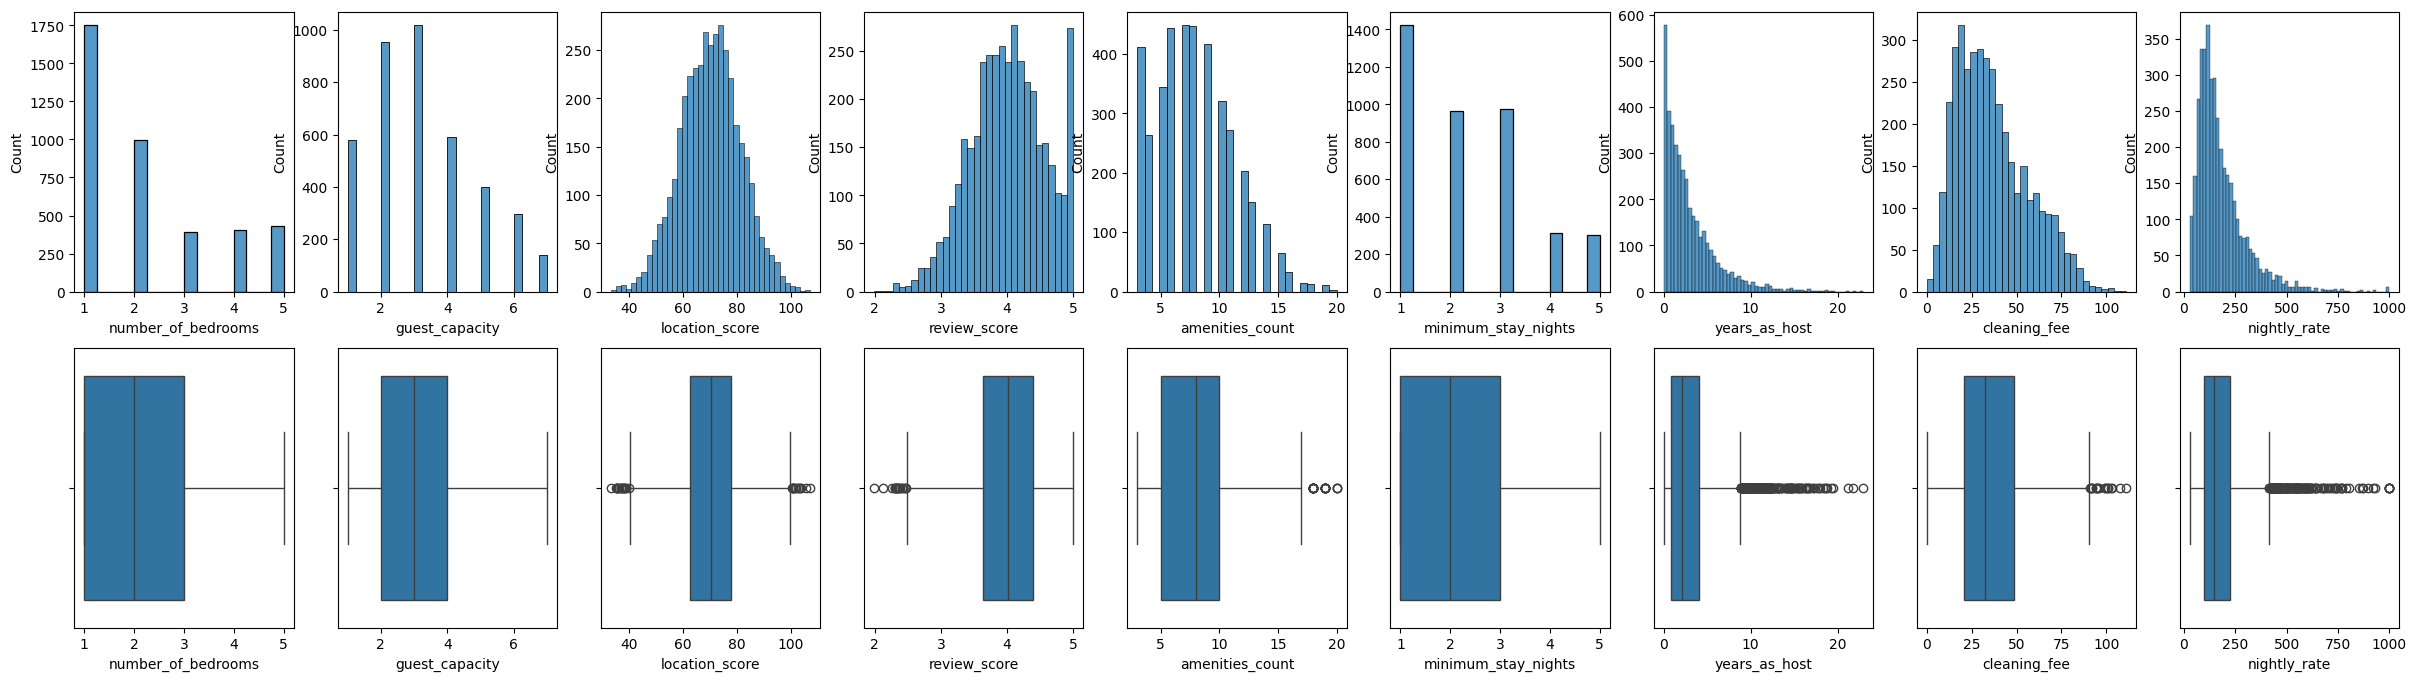

In [7]:
# Histogram and Boxplot for numeric columns
fig, axs = plt.subplots(nrows=2, ncols=9)
fig.set_figwidth(30)
fig.set_figheight(8)

for i in range(len(numeric_columns)):
    sns.histplot(df, x = numeric_columns[i],ax=axs[0,i])  # Histogram
    sns.boxplot(df, x = numeric_columns[i],ax=axs[1,i])   # Boxplot

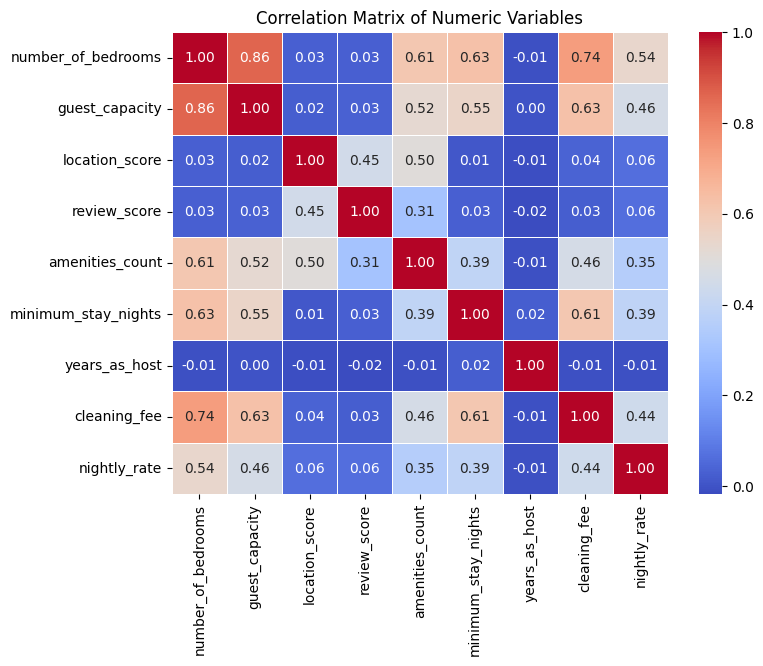

In [8]:
# Correlation matrix for numeric columns
correlation_matrix = df[numeric_columns].corr()

# Correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

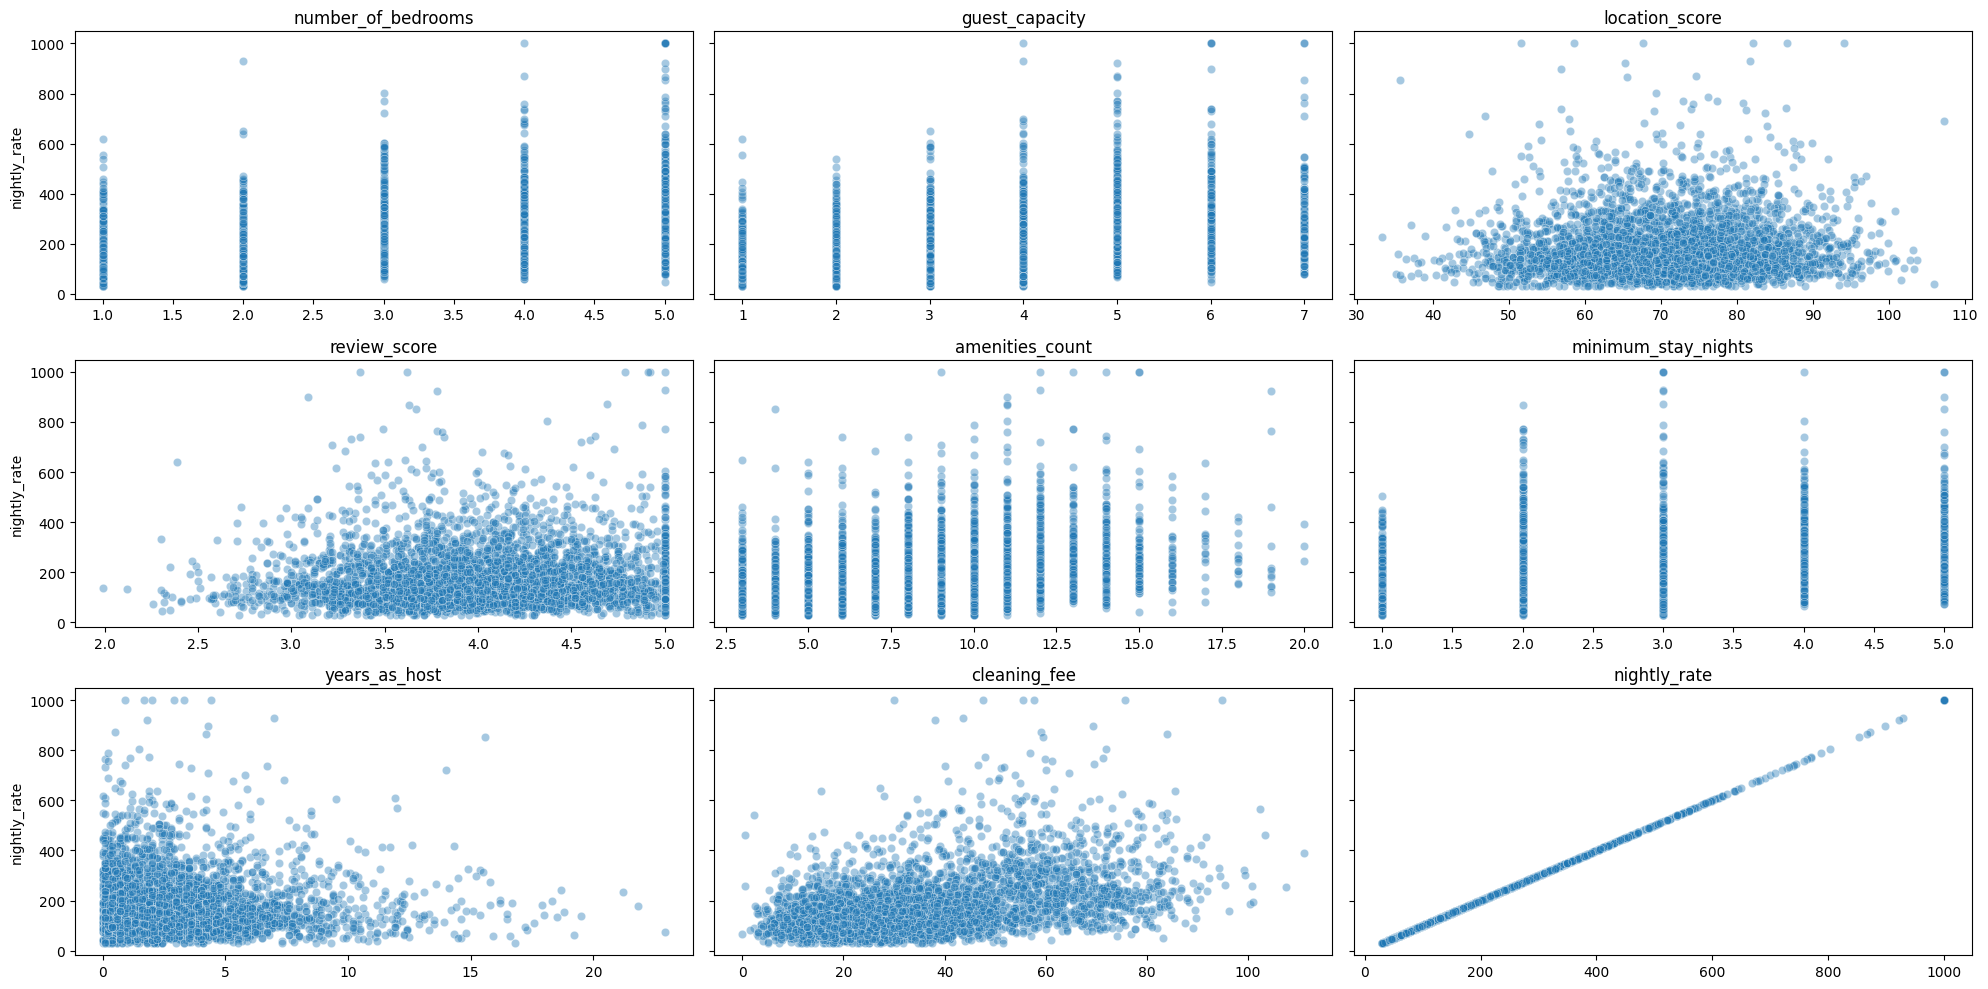

In [9]:
# Create scatterplots of each measure vs. Nightly Rate
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 10), sharey=True)
axs = axs.flatten()

# Plot each numeric column
for ax, col in zip(axs, numeric_columns):
    sns.scatterplot(data=df, x=col, y='nightly_rate', ax=ax, marker='o', alpha=0.4)
    ax.set_title(col)
    ax.set_xlabel('')
plt.tight_layout()
plt.show()


In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Compute VIF for all numeric columns
vif_df = pd.DataFrame({
    'Variable': df[numeric_columns].columns,
    'VIF': [variance_inflation_factor(df[numeric_columns].values, i) for i in range(df[numeric_columns].shape[1])]
}).sort_values(by='VIF', ascending=False)
vif_df

,Variable,VIF
2,location_score,52.321855
3,review_score,44.483941
0,number_of_bedrooms,22.988741
1,guest_capacity,18.848052
4,amenities_count,14.711599
7,cleaning_fee,10.363366
5,minimum_stay_nights,7.828014
8,nightly_rate,4.576058
6,years_as_host,1.987955


#### Category Columns

Univariate
1. *cancellation_policy*: customer prefer flexibility
2. *host_response_time*: Fast communication is important
3. *property_type*: mostly standard apartment
4. *season*: peak season has the highest supply

Bivariate
1. **Luxury house** and **peak season** has higher price
2. No obvious relationship in *cancellation_policy* and *host_response_time* to nightly price

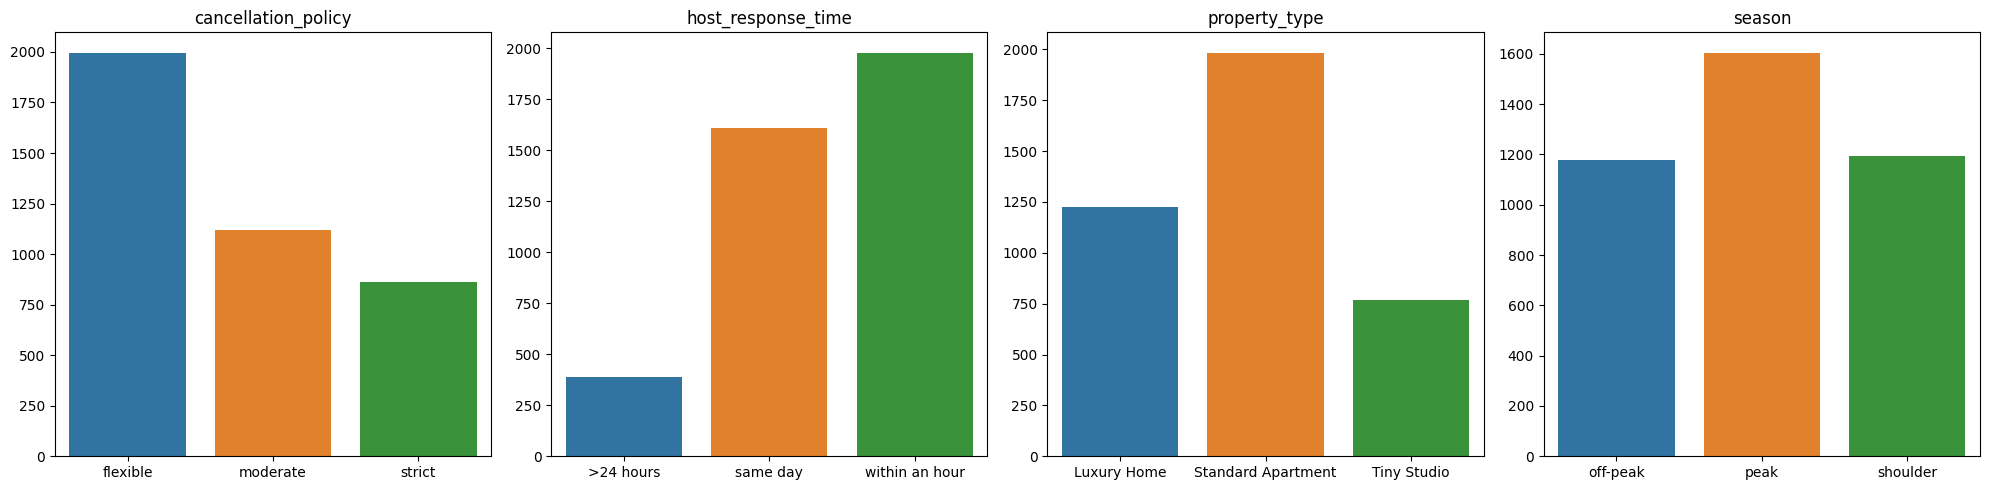

In [11]:
# Create bar charts of the categories (don’t include listing_id)

# Set up figure
fig, axs = plt.subplots(1,4, figsize=(20,5), sharey=False)
axs = axs.flatten()

# Plot each categorical variable
for ax, col in zip(axs, category_columns):
    sns.countplot(data=df, x=col, ax=ax, hue=col)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

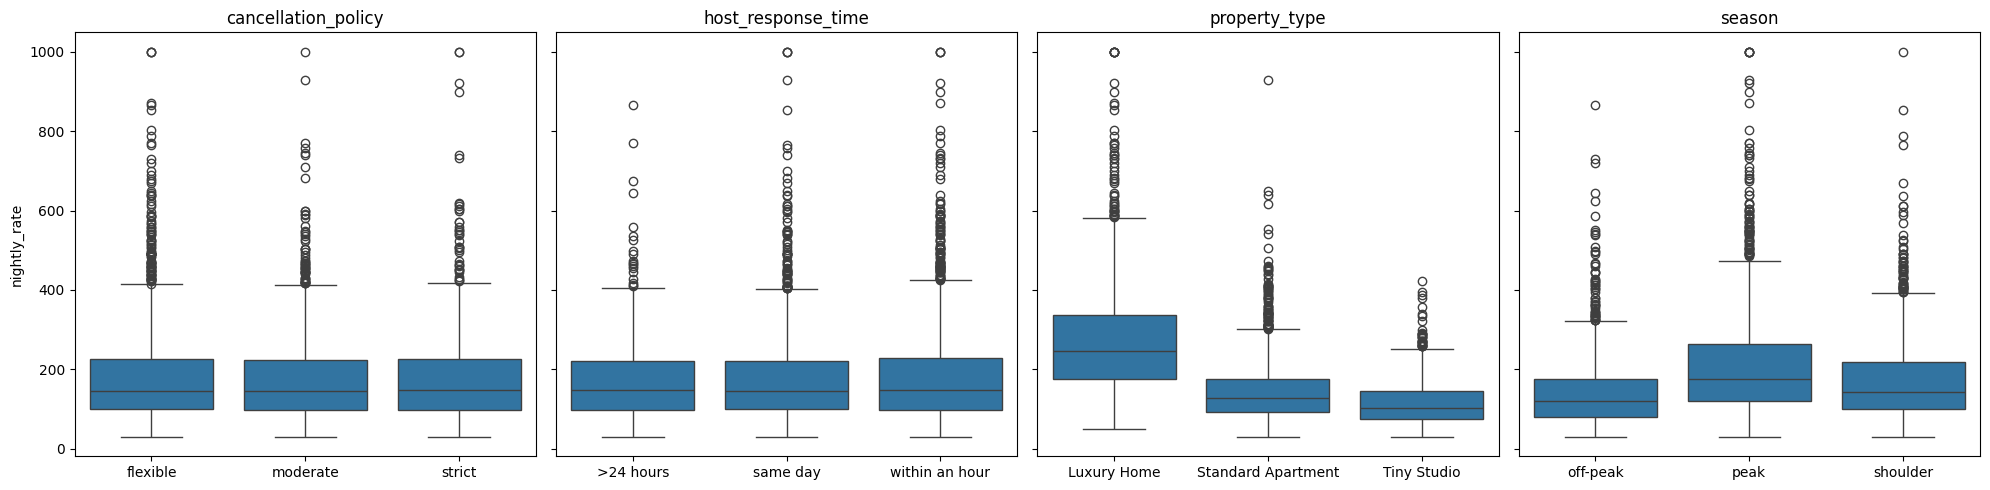

In [12]:
# Create side-by-side boxplots of each category against Nightly Rate
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)
axs = axs.flatten()

# Plot each categorical column
for ax, col in zip(axs, category_columns):
    sns.boxplot(x=df[col], y=df['nightly_rate'], ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

## Statistical Analysis
- Choose at least five hypothesis tests:
    - Example: Compare nightly_rate between different property_types or host_response_time categories.
- Use t-tests or ANOVA for group comparisons.
- Interpret both statistical and practical significance.


### Statistical Analysis

To examine how categorical factors influence pricing, we conducted hypothesis tests using both **ANOVA** and **independent t-tests**.

#### ANOVA Results
We tested whether **nightly rates differ significantly across categories** of:
- cancellation_policy (p = 0.794) and host_response_time (p = 0.407) → **No significant difference** in mean prices.
- property_type (p < 0.0001) and season (p < 0.0001) → **Highly significant effects** on pricing.

#### t-Test Results
We compared binary groups based on logical thresholds:
- **Review Score**: Listings with ratings ≥ 4.5 had significantly higher prices (p = 0.0023).
- **Location Score**: Properties in better locations (≥ 70) were significantly more expensive (p = 0.0018).
- **Cleaning Fee**: High-fee listings (≥ $85) charged much higher nightly rates (p < 0.00001).
- **Host Tenure**: No significant pricing difference between new and experienced hosts (p = 0.15).

#### Interpretation
- **Statistical significance**: Property type, season, location, and review scores are proven differentiators.
- **Practical implication**: Hosts may increase revenue by adjusting listings for higher location ratings, reviews, and targeting peak seasons.


### Compare *nightly_rate* between each category column(*cancellation_policy*, *host_response_time*, *property_type*, *season*)

In [13]:
from scipy import stats

# Define reusable ANOVA function
def anova_test(groups, test_name='ANOVA'):
    result = stats.f_oneway(*groups)
    return pd.DataFrame({
        'Test': [test_name],
        'F-statistic': [result.statistic],
        'p-value': [result.pvalue]
    })

# Define all groupings in one place
group_tests = {
    'Cancellation Policy': [
        df[df['cancellation_policy'] == 'flexible']['nightly_rate'],
        df[df['cancellation_policy'] == 'moderate']['nightly_rate'],
        df[df['cancellation_policy'] == 'strict']['nightly_rate']
    ],
    'Host Response Time': [
        df[df['host_response_time'] == 'within an hour']['nightly_rate'],
        df[df['host_response_time'] == 'same day']['nightly_rate'],
        df[df['host_response_time'] == '>24 hours']['nightly_rate']
    ],
    'Property Type': [
        df[df['property_type'] == 'Luxury Home']['nightly_rate'],
        df[df['property_type'] == 'Standard Apartment']['nightly_rate'],
        df[df['property_type'] == 'Tiny Studio']['nightly_rate']
    ],
    'Season': [
        df[df['season'] == 'off-peak']['nightly_rate'],
        df[df['season'] == 'peak']['nightly_rate'],
        df[df['season'] == 'shoulder']['nightly_rate']
    ]
}

# Run all ANOVA tests and collect results
anova_results = pd.concat(
    [anova_test(groups, test_name=name) for name, groups in group_tests.items()],
    ignore_index=True
)

# Show the results
anova_results

,Test,F-statistic,p-value
0,Cancellation Policy,0.230163,7.944150e-01
1,Host Response Time,0.898658,4.071984e-01
2,Property Type,821.956727,1.772231e-299
3,Season,120.876466,1.092616e-51


In [14]:
import pandas as pd
from scipy import stats

# Define a reusable t-test function
def t_test_groups(group1, group2, description):
    result = stats.ttest_ind(group1, group2, equal_var=False)
    return pd.DataFrame({
        'Comparison': [description],
        't-statistic': [result.statistic],
        'p-value': [result.pvalue]
    })

# 1. High vs Low Review Score
review_threshold = 4.5
high_review = df[df['review_score'] >= review_threshold]['nightly_rate']
low_review = df[df['review_score'] < review_threshold]['nightly_rate']
test1 = t_test_groups(high_review, low_review, 'High Review (≥4.5) vs Low Review (<4.5)')

# 2. Old Host vs New Host
host_threshold = 3.15
old_host = df[df['years_as_host'] >= host_threshold]['nightly_rate']
new_host = df[df['years_as_host'] < host_threshold]['nightly_rate']
test2 = t_test_groups(old_host, new_host, 'Old Host (≥3.15 years) vs New Host (<3.15 years)')

# 3. High vs Low Location Score
location_threshold = 70
high_location = df[df['location_score'] >= location_threshold]['nightly_rate']
low_location = df[df['location_score'] < location_threshold]['nightly_rate']
test3 = t_test_groups(high_location, low_location, 'High Location Score (≥70) vs Low Location Score (<70)')

# 4. Cleaning Fee Impact
cleaning_fee_threshold = 85
high_cleaning_fee = df[df['cleaning_fee'] >= cleaning_fee_threshold]['nightly_rate']
low_cleaning_fee = df[df['cleaning_fee'] < cleaning_fee_threshold]['nightly_rate']
test4 = t_test_groups(high_cleaning_fee, low_cleaning_fee, 'High Cleaning Fee (≥85) vs Low Cleaning Fee (<$85)')

# Combine all results
t_test_results = pd.concat([test1, test2, test3, test4], ignore_index=True)

# Display
t_test_results

,Comparison,t-statistic,p-value
0,High Review (≥4.5) vs Low Review (<4.5),3.052963,0.002318
1,Old Host (≥3.15 years) vs New Host (<3.15 years),-1.433972,0.151688
2,High Location Score (≥70) vs Low Location Scor...,3.128038,0.001773
3,High Cleaning Fee (≥85) vs Low Cleaning Fee (<...,5.432360,0.000002


## Predictive Modeling
- Modeling Objective: Predict nightly_rate using the available listing and host attributes, with a focus on inference and interpretability, not just prediction accuracy.
### Model 1 – Linear Regression (for inference):
- Fit a multiple linear regression model using appropriately preprocessed features.
- Interpret key coefficients:
    - Identify variables with the strongest influence on pricing.
    - Discuss the direction (positive/negative) and scale of effects.
- Check assumptions and diagnostics:
    - Residual plots, Q-Q plots, multicollinearity (e.g., VIF)
- Evaluate assumptions and diagnostics
    - Use residual plots, Q-Q plots, and VIF to assess model fit

In [15]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder

def linear_reg_model(df, response='nightly_rate', predictors=None):
    if 'const' in predictors:
        predictors.remove('const')
        
    # Separate response and features
    X = df[predictors]
    y = df[response]

    # Detect types automatically
    categorical_cols = X.select_dtypes(include=['category']).columns.tolist()
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # One-hot encode categorical variables
    if categorical_cols:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        X_encoded = encoder.fit_transform(X[categorical_cols])
        encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
        X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names, index=X.index)
    else:
        X_encoded_df = pd.DataFrame(index=X.index)

    # Combine numeric and encoded features
    X_processed = pd.concat([X[numeric_cols], X_encoded_df], axis=1)

    # Add constant
    X_processed = sm.add_constant(X_processed)

    # Fit OLS model
    ols_model = sm.OLS(y, X_processed).fit()

    # Calculate VIF (excluding constant)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_processed.columns.drop('const')
    vif_data["VIF"] = [variance_inflation_factor(X_processed.drop(columns='const').values, i)
                       for i in range(X_processed.drop(columns='const').shape[1])]

    return ols_model, vif_data

#### Full Model
Filtering important features from statistical analysis
1. *listing_id* is not a predictor and *nightly_rate* is the response variable, so we drop them from the predictors list
2. *cleaning_fee* and *guest_capacity* are highly correlated with *num_of_bedrooms*, so we will not include them as predictors
3. *cancellation_policy* and *host_reposonse_time* are not statistically significant in the ANOVA tests, so we will not include them as predictors

In [16]:
predictors = df.columns.drop(['listing_id', 'nightly_rate', 'cleaning_fee', 'guest_capacity', 'cancellation_policy', 'host_response_time']).tolist()

full_model, full_vif_data = linear_reg_model(df=df, response='nightly_rate', predictors=predictors)

# Output
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nightly_rate   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     232.8
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        14:32:04   Log-Likelihood:                -23804.
No. Observations:                3978   AIC:                         4.763e+04
Df Residuals:                    3967   BIC:                         4.770e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               96.1748     18.610      5.168      0.000      59.688     132.662
number_of_bedrooms                  21.4849      2.847      7.545      0.000      15.902      27.067
location_score                       0.4152      0.182      2.287      0.022       0.059       0.771
review_score                         4.5162      3.075      1.468      0.142      -1.513      10.546
amenities_count                      0.2487      0.729      0.341      0.733      -1.181       1.678
minimum_stay_nights                  2.0260      1.796      1.128      0.259      -1.496       5.548
years_as_host                       -0.0148      0.512     -0.029      0.977      -1.019       0.990
property_type_Standard Apartment   -75.2417      8.056     -9.340      0.000     -91.036     -59.448
property_type_Tiny Studio          -89.1038     10.268     -8.678      0.000    -109.235     -68.973
season_peak                         72.2881      3.693     19.574      0.000      65.048      79.529
season_shoulder                     29.8229      3.952      7.547      0.000      22.075      37.571
==============================================================================
Omnibus:                     1755.269   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13750.121
Skew:                           1.924   Prob(JB):                         0.00
Kurtosis:                      11.255   Cond. No.                         993.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
full_vif_data.sort_values(by='VIF', ascending=False)

# location_score and review_score exceed 50 → severe multicollinearity.
# amenities_count and number_of_bedrooms also show high VIFs (>10), which can distort coefficients.

,Variable,VIF
1,location_score,60.933424
2,review_score,53.941956
3,amenities_count,15.774116
0,number_of_bedrooms,13.705687
4,minimum_stay_nights,8.189792
6,property_type_Standard Apartment,7.824472
7,property_type_Tiny Studio,5.052869
8,season_peak,2.343584
5,years_as_host,2.004110
9,season_shoulder,2.002157


#### Significant Variables Model
- not significant(p-value>0.05): *amenities_count*, *years_as_host*, *review_score*, *minimum_stay_nights*
- high VIF(multicollinearity, VIF>10): *location_score*, *review_score*, *amenities_count*, *number_of_bedrooms*
- Drop **amenities_count** and **review_score**, which are both not significant and severe multicollinearity

In [18]:
sig_predictors = df.columns.drop(['listing_id', 'nightly_rate', 'cleaning_fee', 'guest_capacity', 'cancellation_policy', 'host_response_time', 'amenities_count', 'review_score']).tolist()

sig_model, sig_vif_data = linear_reg_model(df=df, response='nightly_rate', predictors=sig_predictors)

# Output
sig_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nightly_rate   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     290.6
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        14:32:04   Log-Likelihood:                -23805.
No. Observations:                3978   AIC:                         4.763e+04
Df Residuals:                    3969   BIC:                         4.768e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              105.9123     16.298      6.499      0.000      73.960     137.865
number_of_bedrooms                  21.7762      2.654      8.205      0.000      16.573      26.979
location_score                       0.5529      0.137      4.031      0.000       0.284       0.822
minimum_stay_nights                  2.0715      1.796      1.153      0.249      -1.450       5.593
years_as_host                       -0.0250      0.512     -0.049      0.961      -1.030       0.980
property_type_Standard Apartment   -75.4812      8.055     -9.371      0.000     -91.273     -59.689
property_type_Tiny Studio          -89.3471     10.267     -8.702      0.000    -109.477     -69.217
season_peak                         72.4201      3.692     19.616      0.000      65.182      79.658
season_shoulder                     29.9610      3.951      7.583      0.000      22.215      37.707
==============================================================================
Omnibus:                     1760.623   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13893.878
Skew:                           1.929   Prob(JB):                         0.00
Kurtosis:                      11.303   Cond. No.                         917.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
sig_vif_data.sort_values(by='VIF', ascending=False)

,Variable,VIF
1,location_score,26.147171
0,number_of_bedrooms,11.407901
2,minimum_stay_nights,7.838481
4,property_type_Standard Apartment,6.157593
5,property_type_Tiny Studio,3.993071
6,season_peak,2.327081
3,years_as_host,2.001926
7,season_shoulder,1.993304


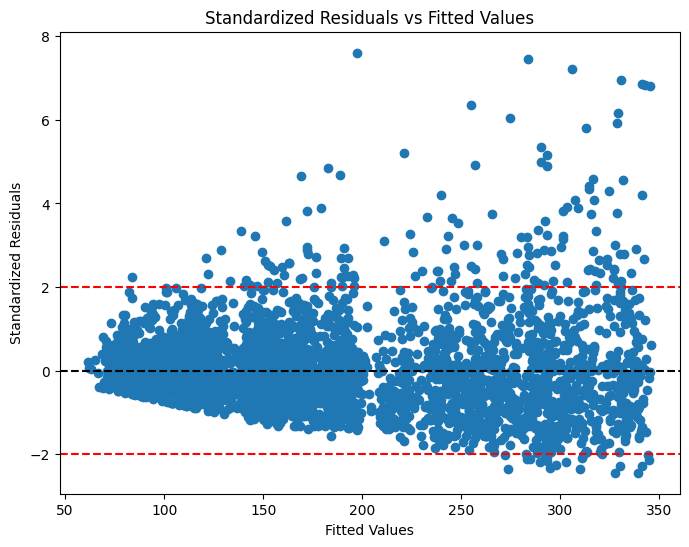

In [20]:
# Plotting the residuals

def standardized_residuals_plot(model = sig_model):
    # Standardized Residuals Plot (Residuals vs Fitted Values)
    plt.figure(figsize=(8, 6))
    plt.scatter(model.fittedvalues, model.get_influence().resid_studentized_internal)
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(2, color='red', linestyle='--', label='±2 Threshold')
    plt.axhline(-2, color='red', linestyle='--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Standardized Residuals")
    plt.title("Standardized Residuals vs Fitted Values")
    plt.show()

standardized_residuals_plot(sig_model)

<Figure size 800x600 with 0 Axes>

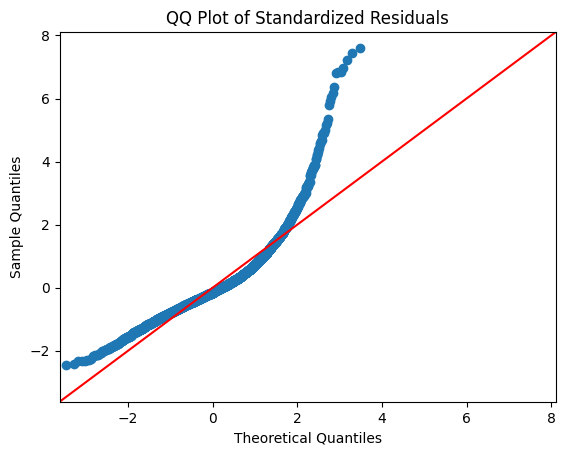

In [21]:
# QQ Plot

def qqplot(model=sig_model):
    plt.figure(figsize=(8, 6))
    sm.qqplot(model.get_influence().resid_studentized_internal, line='45', fit=True)
    plt.title("QQ Plot of Standardized Residuals")
    plt.show()
    
qqplot(sig_model)

#### Improved Model
##### 1. Log nightly_price

In [22]:
# Log Transformation of Nightly Rate
df_log_price = df.copy()
df_log_price['log_nightly_rate'] = np.log(df_log_price['nightly_rate'])
df_log_price = df_log_price.drop(columns=['nightly_rate'])
df_log_price.describe()

,number_of_bedrooms,guest_capacity,location_score,review_score,amenities_count,minimum_stay_nights,years_as_host,cleaning_fee,log_nightly_rate
count,3978.000000,3978.000000,3978.000000,3978.000000,3978.000000,3978.000000,3978.000000,3978.000000,3978.000000
mean,2.186275,3.182504,70.319040,4.003914,7.944444,2.273002,3.002916,36.345975,5.009613
std,1.373898,1.604738,11.133952,0.559951,3.350407,1.236597,2.980482,19.762839,0.605865
min,1.000000,1.000000,33.330000,1.990000,3.000000,1.000000,0.000000,0.020000,3.401197
25%,1.000000,2.000000,62.750000,3.630000,5.000000,1.000000,0.900000,20.610000,4.598523
50%,2.000000,3.000000,70.435000,4.010000,8.000000,2.000000,2.100000,32.695000,4.992675
75%,3.000000,4.000000,77.780000,4.390000,10.000000,3.000000,4.100000,48.730000,5.420745
max,5.000000,7.000000,107.260000,5.000000,20.000000,5.000000,22.900000,111.100000,6.907755


##### 2. Remove outliers using IQR method

In [23]:
# remove outliers using IQR method
def iqr_outliers_removal(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
        
df_log_price = iqr_outliers_removal(df_log_price, ['location_score', 'cleaning_fee', 'amenities_count'])
df_log_price.describe()

,number_of_bedrooms,guest_capacity,location_score,review_score,amenities_count,minimum_stay_nights,years_as_host,cleaning_fee,log_nightly_rate
count,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000
mean,2.163850,3.157450,70.225783,4.001429,7.861495,2.260369,3.013210,35.943454,5.003063
std,1.357969,1.586609,10.760486,0.558616,3.224906,1.231283,2.984057,19.281982,0.602764
min,1.000000,1.000000,40.470000,1.990000,3.000000,1.000000,0.000000,0.020000,3.401197
25%,1.000000,2.000000,62.755000,3.630000,5.000000,1.000000,0.900000,20.505000,4.594438
50%,2.000000,3.000000,70.315000,4.000000,8.000000,2.000000,2.100000,32.500000,4.988560
75%,3.000000,4.000000,77.567500,4.390000,10.000000,3.000000,4.200000,48.147500,5.409456
max,5.000000,7.000000,99.910000,5.000000,17.000000,5.000000,22.900000,90.640000,6.907755


In [24]:
improve_predictors = df_log_price.columns.drop(['listing_id', 'log_nightly_rate', 'cleaning_fee', 'guest_capacity', 'cancellation_policy', 'host_response_time', 'amenities_count', 'review_score']).tolist()
improve_model, improve_vif_data = linear_reg_model(df=df_log_price, response='log_nightly_rate', predictors=improve_predictors)

# Output
improve_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_nightly_rate   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     323.3
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        14:32:05   Log-Likelihood:                -2570.4
No. Observations:                3906   AIC:                             5159.
Df Residuals:                    3897   BIC:                             5215.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                4.5724      0.081     56.269      0.000       4.413       4.732
number_of_bedrooms                   0.0993      0.013      7.577      0.000       0.074       0.125
location_score                       0.0040      0.001      5.784      0.000       0.003       0.005
minimum_stay_nights                  0.0055      0.009      0.626      0.531      -0.012       0.023
years_as_host                     4.675e-05      0.003      0.019      0.985      -0.005       0.005
property_type_Standard Apartment    -0.3962      0.039    -10.038      0.000      -0.474      -0.319
property_type_Tiny Studio           -0.5460      0.050    -10.849      0.000      -0.645      -0.447
season_peak                          0.4190      0.018     23.160      0.000       0.384       0.454
season_shoulder                      0.1929      0.019      9.962      0.000       0.155       0.231
==============================================================================
Omnibus:                        5.394   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                5.334
Skew:                          -0.084   Prob(JB):                       0.0694
Kurtosis:                       3.066   Cond. No.                         922.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
improve_vif_data.sort_values(by='VIF', ascending=False)

,Variable,VIF
1,location_score,27.046181
0,number_of_bedrooms,11.394604
2,minimum_stay_nights,7.867560
4,property_type_Standard Apartment,6.379708
5,property_type_Tiny Studio,4.150435
6,season_peak,2.310229
3,years_as_host,2.006610
7,season_shoulder,1.978422


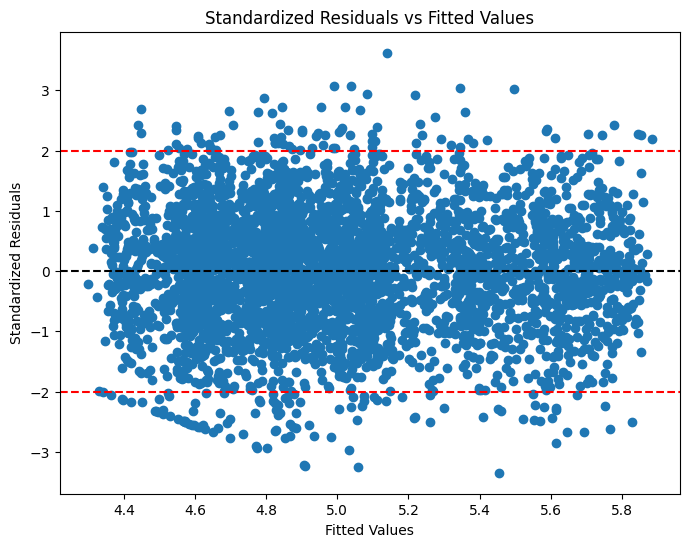

In [26]:
standardized_residuals_plot(improve_model)

<Figure size 800x600 with 0 Axes>

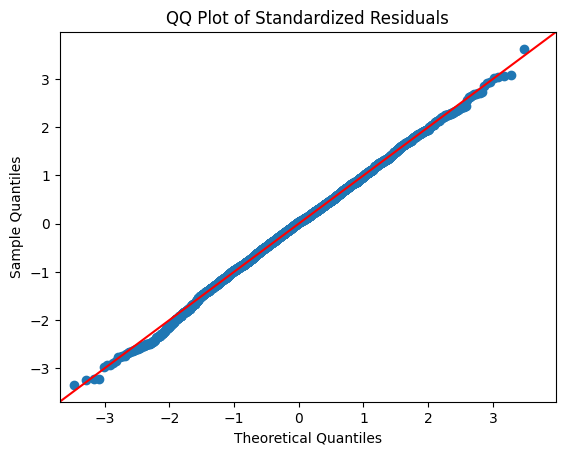

In [27]:
qqplot(improve_model)

### Model 2 – Decision Tree
- Fit a Decision Tree Regression model using the same feature set.
- Set maximum depth or minimum samples per leaf to prevent overfitting.
- Visualize the full tree or a pruned version (e.g., using plot_tree or export_graphviz).
- Interpret how the tree splits:
    - What are the key decision rules?
    - How does the model segment listings into different pricing tiers?
- Compare performance to the linear model using R² and MAE on test data.

In [28]:
df_decision_tree = pd.concat([df_log_price[improve_predictors], df_log_price[['log_nightly_rate']]], axis=1)
df_decision_tree['property_type'] = df_decision_tree['property_type'].map({'Tiny Studio': 0, 'Standard Apartment': 1, 'Luxury Home':2})  # Convert categorical to numerical
df_decision_tree['season'] = df_decision_tree['season'].map({'off-peak': 0, 'shoulder': 1, 'peak':2})  # Convert categorical to numerical
df_decision_tree

,property_type,number_of_bedrooms,location_score,season,minimum_stay_nights,years_as_host,log_nightly_rate
0,1,2,75.17,2,2,1.6,5.232658
1,1,2,67.07,0,2,4.1,5.543770
2,1,1,76.57,0,1,2.3,4.140273
3,1,2,88.14,1,2,1.6,5.317139
5,0,1,72.66,1,1,0.4,4.969883
...,...,...,...,...,...,...,...
3977,1,2,85.06,2,2,2.7,5.380128
3978,1,2,79.33,2,1,2.3,5.010035
3979,1,2,58.11,0,3,0.7,4.271933
3980,1,2,89.51,2,1,1.8,5.028410


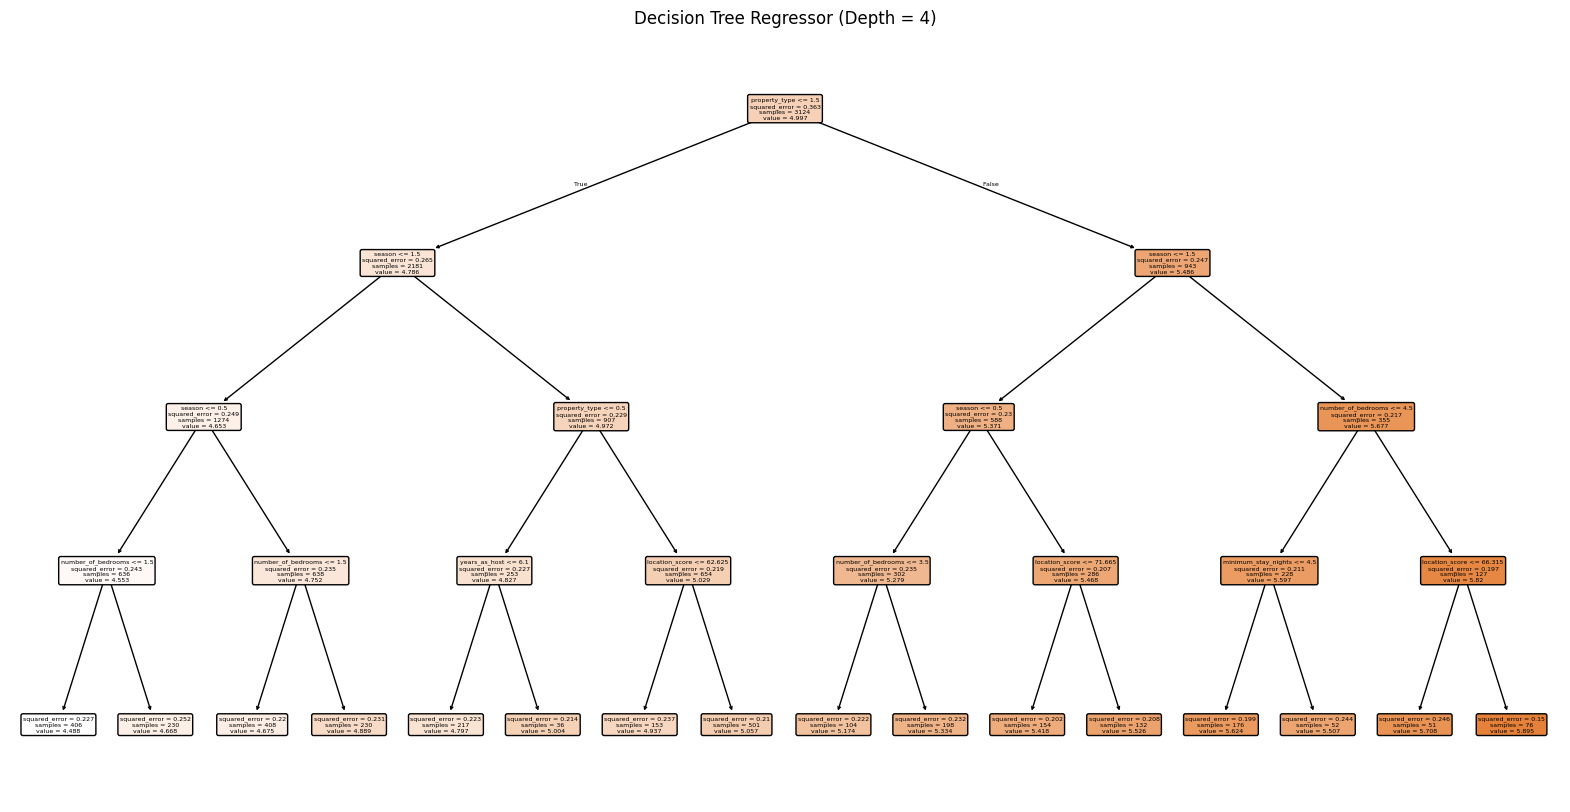

Decision Tree R²: 0.393
Decision Tree MAE: 0.36


In [29]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Prepare features and target
X = df_decision_tree[improve_predictors]  # Same cleaned predictors as used in OLS model
y = df_decision_tree['log_nightly_rate']  # Use raw or log-transformed depending on what you want to compare

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Fit Decision Tree with constraints
tree_model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20, random_state=42)
tree_model.fit(X_train, y_train)

# 4. Visualize the tree (pruned at max_depth=4)
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree Regressor (Depth = 4)")
plt.show()

# 5. Evaluate performance
y_pred_tree = tree_model.predict(X_test)
r2_tree = r2_score(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)

print(f"Decision Tree R²: {r2_tree:.3f}")
print(f"Decision Tree MAE: {mae_tree:.2f}")


- decision tree explains 39.3% of the variance in nightly rates
- the model's predictions are $36 off from the log nightly rate.

## Model Interpretation Techniques
### Global Explaniability
The decision tree model provides insight into which features most strongly influence nightly pricing by calculating feature importance based on how much each feature reduces error across all splits.


1. Top Features
- property_type (Importance = 0.74): The most dominant feature, Indicating that the type of property (e.g., Luxury Home, Tiny Studio) plays a critical role in determining price.
- season (Importance = 0.21): Listings in peak seasons are priced significantly higher.
- number_of_bedrooms (Importance = 0.04): Still relevant, but its importance is much smaller compared to categorical variables.
  
2. Lower-Impact Features
- location_score, years_as_host, and minimum_stay_nights had minimal influence in the tree model.
- This suggests either:
  - The effects are nonlinear and sparsely impactful.
  - Or their influence is captured by other stronger, correlated features.

In [30]:
# Global explainability: Feature Importances
feature_importances = tree_model.feature_importances_
feature_importances_df = pd.DataFrame({ 
    'Feature': ['property_type', 'number_of_bedrooms', 'location_score', 'season', 'minimum_stay_nights','years_as_host'],
    'Importance': feature_importances
})
# Sort the DataFrame by importance 
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)

               Feature  Importance
0        property_type    0.740896
3               season    0.208060
1   number_of_bedrooms    0.038831
2       location_score    0.008037
5        years_as_host    0.002958
4  minimum_stay_nights    0.001218


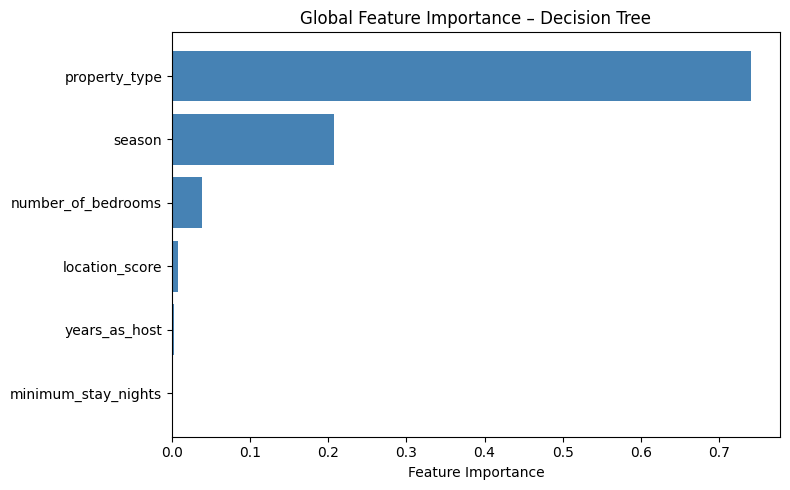

In [31]:
# Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='steelblue')
plt.xlabel('Feature Importance')
plt.title('Global Feature Importance – Decision Tree')
plt.gca().invert_yaxis()  # So the most important feature is at the top
plt.tight_layout()
plt.show()

### Local explainability
- Use at least one local explanation technique:
    - SHAP values or Partial Dependence Plots (PDP)
- For SHAP:  
    - Show a summary plot to highlight the most influential features.
    - Show a dependence plot for one continuous feature (e.g., number_of_bedrooms or location_score).
    - Explain what these results tell us about price drivers beyond what the linear model reveals.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


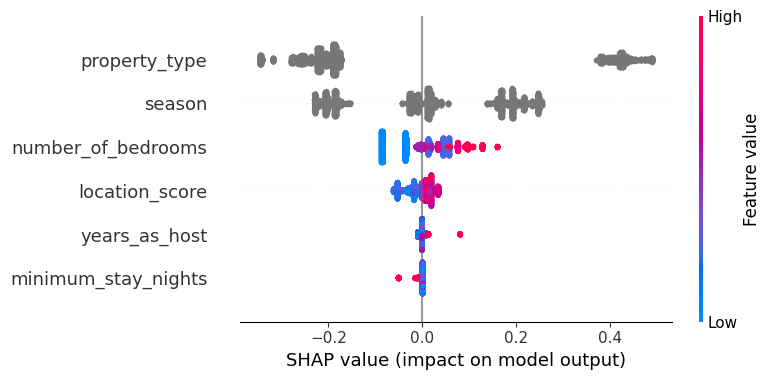

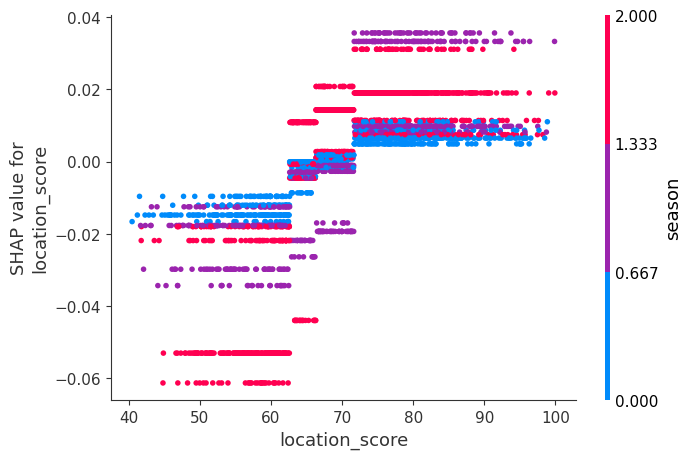

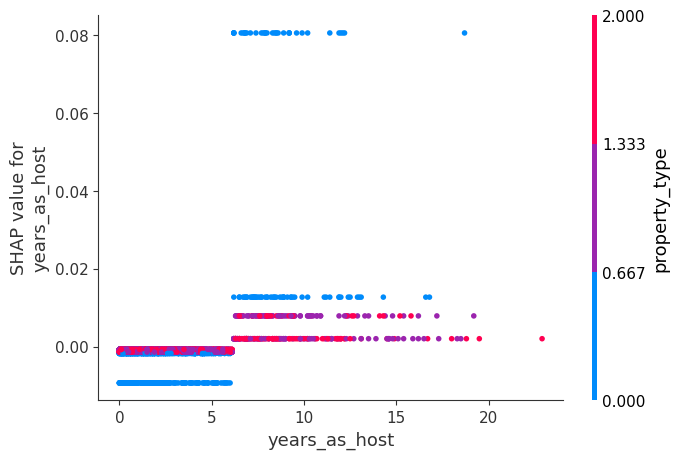

In [ ]:
import shap

# Use exact explainer for linear models
explainer = shap.Explainer(tree_model, X_train)

# Compute SHAP values
shap_values = explainer(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)

shap.dependence_plot(
    ind="location_score",                          # the feature name or index
    shap_values=shap_values.values,                # convert Explanation → ndarray
    features=X_train.values,                       # raw numpy array
    feature_names=X_train.columns.tolist(),        # retain feature names
)

shap.dependence_plot(
    ind="years_as_host",                          # the feature name or index
    shap_values=shap_values.values,                # convert Explanation → ndarray
    features=X_train.values,                       # raw numpy array
    feature_names=X_train.columns.tolist(),        # retain feature names
    
)

**SHAP Summary Plot Interpretation**  
This plot ranks features by their overall impact on the model's predictions.  
- property_type and season have the largest influence on nightly rate.
- Color gradients indicate how high or low feature values (e.g., number of bedrooms) affect predictions.
- Most features show both positive and negative contributions depending on their value.

**SHAP Dependence Plot: Location Score**  
Higher location_score values are associated with increasing SHAP values, meaning they tend to raise predicted prices.  
- Listings in peak season (shown in red) amplify this effect.
- The trend is nonlinear, showing a steep rise around higher scores (above ~70), especially during peak times.

**SHAP Dependence Plot: Years as Host**  
This feature has a relatively weak influence on pricing predictions.  
- SHAP values cluster around zero across the range of years_as_host.
- Newer hosts (left side) may slightly reduce prices, but the effect is minimal and shows little interaction with property type.

### Discussion
- Compare interpretability and inference between the linear and tree-based models.
- Identify any nonlinear effects or feature interactions detected by the tree-based model that were missed by the linear model.
- Summarize what each model contributes to your understanding of pricing behavior.

### Discussion: Linear vs. Tree-Based Model Interpretation

#### Interpretability & Inference

- **Linear Regression** offers **clear coefficients** and direct interpretability: each unit increase in a variable translates to a fixed price change (e.g., +$21 per bedroom). 
- However, it assumes **linear relationships and additivity**, limiting its ability to capture real-world pricing dynamics.
- **Decision Trees**, while less transparent in form, enable interpretation through **feature importance**, **decision paths**, and **SHAP values**, revealing more complex relationships.

#### Nonlinear Effects & Interactions

- The tree-based model uncovered **nonlinear effects**:
  - location_score only significantly impacts pricing at very high values, especially during peak seasons (as seen in SHAP dependence plots).
  - season interacts with other features—e.g., the impact of property_type is magnified in peak season.
- These effects were **not captured** by the linear model, which treats relationships as fixed and independent.

#### Model Contributions to Pricing Insight

| Model Type     | Contributions to Understanding Pricing |
|----------------|----------------------------------------|
| **Linear Model** | Quantifies baseline effects; helps identify statistically significant predictors. Good for inference and hypothesis testing. |
| **Tree-Based Model** | Captures thresholds, interactions, and nonlinear jumps. SHAP explains complex behavior in pricing. Better for accurate prediction and real-world decision support. |

#### Conclusion
- **Use the linear model** to establish interpretable, general pricing rules.
- **Use the tree-based model** to understand detailed pricing behavior and offer customized, context-aware recommendations to hosts.



## Cluster Analysis
- Select a subset of features for consumer-oriented clustering (e.g., price, size, amenities).
- Normalize features and apply KMeans or DBSCAN.
- Use PCA to visualize clusters in 2D.
- Interpret clusters: label and describe them (e.g., Budget, Mid-Tier, Luxury).

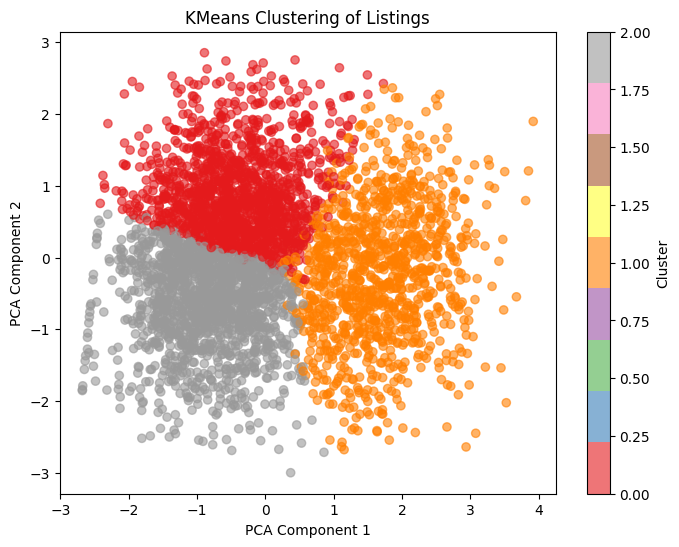

,log_nightly_rate,number_of_bedrooms,location_score
cluster,,,
0,4.90,1.47,79.32
1,5.60,4.06,69.84
2,4.66,1.44,61.96


In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def cluster_analysis(df=df, cluster_features = ['nightly_rate', 'number_of_bedrooms', 'location_score']):
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[cluster_features])

    # Choose number of clusters
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)

    # Reduce to 2D for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Plot clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='Set1', alpha=0.6)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("KMeans Clustering of Listings")
    plt.colorbar(label='Cluster')
    plt.show()

    cluster_summary = df.groupby('cluster')[cluster_features].mean().round(2)

    return cluster_summary

cluster_analysis(df=df_log_price, cluster_features=['log_nightly_rate', 'number_of_bedrooms', 'location_score'])

| Cluster | Label           | Description                                                                 |
|---------|------------------|-----------------------------------------------------------------------------|
| 0       | Urban Budget     | Low bedroom count, high location score, moderate price → Ideal for solo travelers or couples looking for centrally located budget stays. |
| 1       | Luxury Family    | High number of bedrooms, high price, decent location → Large, premium listings suitable for families or groups. |
| 2       | Economy          | Fewer bedrooms, lower location score, and lowest price → Basic accommodations, likely in less central areas. |


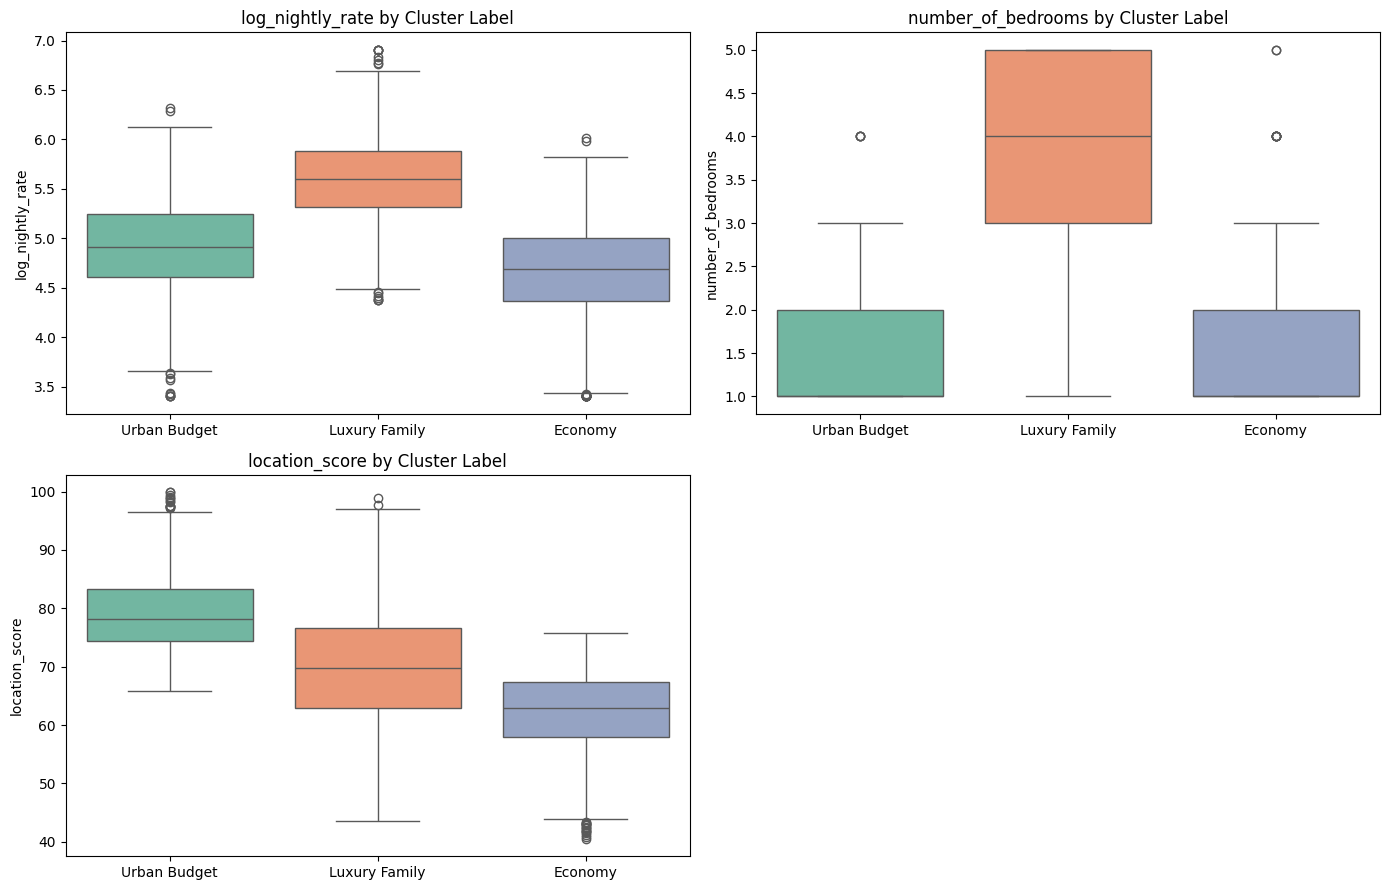

In [66]:
# Map cluster numbers to readable labels
label_map = {
    0: "Urban Budget",
    1: "Luxury Family",
    2: "Economy"
}
df_log_price['cluster_label'] = df_log_price['cluster'].map(label_map)

# Features to plot
features_to_plot = ['log_nightly_rate', 'number_of_bedrooms', 'location_score']

# Create boxplots
plt.figure(figsize=(14, 9))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(
        data=df_log_price,
        x='cluster_label',
        y=feature,
        hue='cluster_label',        # assign hue
        palette='Set2',             # apply color
        legend=False                # hide redundant legend
    )
    plt.title(f'{feature} by Cluster Label')
    plt.xlabel("")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


## Summary & Conclusions

This project explored key drivers of Airbnb pricing using both statistical and machine learning techniques to inform pricing strategy and listing optimization.

#### Synthesized Insights
- **EDA** revealed price variability, outliers, and skewed distributions, especially in nightly_rate and cleaning_fee.
- **Linear regression** quantified baseline effects: each bedroom increases price, and peak season strongly drives higher rates. However, it missed nonlinearities and interactions.
- **Decision tree modeling** improved predictive accuracy (R² = 0.393) and, through SHAP, uncovered nuanced patterns like the amplified impact of location score during peak seasons and interactions between property type and time of year.
- **Cluster analysis** identified three listing profiles (Urban Budget, Luxury Family, Economy), offering targeted strategies for pricing and promotion.

#### Business Connection
These insights support Airbnb hosts and platform managers by:
- Providing **data-driven pricing recommendations** based on season, property type, and location.
- Enabling **audience segmentation** to tailor offerings and improve market positioning.
- Improving **model transparency** through SHAP for stakeholder trust and decision-making.

#### Assumptions & Limitations
- Assumes data quality and representative sample; external factors (e.g., events, host quality) not captured.
- Linear model assumes independence and normality of residuals; decision tree can overfit without tuning.
- Clustering was based on a limited feature set; more dimensions could enhance grouping.

#### Next Steps
- Test **advanced models** (e.g., Random Forest, XGBoost) for further accuracy.
- Expand clustering with more features (e.g., amenities, cancellation policy).
- Use real-time data and integrate with booking trends for dynamic pricing.

